In [13]:
from lma.jupyter.setupJupyter import setupJupyter; setupJupyter(plotStyle='paper') #plotTheme='light',
import h5py
from pathlib import Path
import numpy as np
import matplotlib as mpl

In [124]:
def getdata(hdfpth, names, cols):
    with h5py.File(hdfpth) as f:
        return [[f[name][col] for col in cols] for name in names]
    
def Y(k, t, m):
    t = np.asarray(t)
    return [
        np.ones(t.size)*m[0],
        k[0]*m[0]/k[2] + np.exp(-t*k[2])*(m[1] - k[0]*m[0]/k[2]),
        k[0]*k[1]*m[0]/(k[2]*k[3]) + 
            np.exp(-t*k[2])*k[1]*(k[0]*m[0] - k[2]*m[1])/(k[2]*(k[2] - k[3])) + 
            np.exp(-t*k[3])*(m[2] + k[1]*(k[3]*m[1] - k[0]*m[0])/(k[3]*(k[2] - k[3])))
    ]

def plotts(data, ref_data=None, bins=None, binrange=None, labelx=True, labely=True, labelmeans=False, truncate=None,
           tickperiod=2, ylim=None, yticks=None,
           twinx=False, fig=None, axarr=None, axlab=None, **fig_kw):
    if fig is None and axarr is None:
        fig,axarr,axlab = ph.figAxArr([len(data), 2], axlab=True, sharey='row',
                                      gridspec_kw={'width_ratios': [2.5,1], 'wspace': 0, 'hspace': 0}, **fig_kw)
    
    # twin the xaxes
    if twinx:
        axarr[0,1].get_shared_x_axes().join(*axarr[:,1])
    
    hs = []
    for i,(d,axrow) in enumerate(zip(np.asarray(data), axarr)):
        x,y = d if truncate is None else d[:,:truncate]
        ax,axhist = axrow
        ax.plot(x, y, color="k", lw=.3)
        if ref_data is not None:
            ax.plot(*ref_data[i], color='C3', alpha=.5)
        dx = x.max() - x.min()
        ax.set_xlim(x.min() - dx*.02, x.max())
        
        if yticks is not None:
            ax.set_yticks(yticks)
            
        if ylim is None:
            if yticks is None:
                ax.set_ylim(-.5, 1.1*y.max())
            else:
                ax.set_ylim(-.5, 1.1*yticks[-1])
        else:
            ax.set_ylim(*ylim)
        
#         if binrange is None: binrange = (0, d[1].max())
        histkw = {'bins': np.arange(-.5, np.ceil(d[1].max()) + .5) if bins is None else bins,
                  'range': binrange}
        h = axhist.hist(d[1], lw=.3, ec="k", fc="none", histtype='stepfilled', orientation="horizontal", density=True, **histkw)
        hs.append(h)
#         ph.hideAxesTicks(axhist)
            
        if labelmeans:
            det_mean = ref_data[i][1].mean()
            stoch_mean = d[1].mean()
            axhist.hline([det_mean, stoch_mean], 0, 1, colors=['k', 'C3'], linestyles=['dashed', 'dashed'])
            
            print('deterministic, mean: %.2f' % det_mean)
            print('stochastic, mean: %.2f' % stoch_mean)
        
#         if labelmeans:
#             ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left") #prop={'size': 6})
        
    ph.reticktime(x, 'h', ax.xaxis, period=tickperiod, droplast=True)
    
    if labelx:
        axarr[-1,0].set_xlabel('time (h)')
        axarr[-1,1].set_xlabel('p(count)')
    
    if labely:
        axlab.set_ylabel('protein count', labelpad=20)
    
    return fig,axarr,axlab

In [ ]:
ax.hlines

In [125]:
from collections import OrderedDict

kdict = OrderedDict([
    ('no_var', [1e1, 1e-1, 1e-1, 2e-3]),
    ('min_var', [1e1, 1e-3, 1e0, 2e-4]),
    ('low_var', [1e-1, 1e-1, 1e-1, 2e-3]),
    ('high_var', [1e-2, 1e0, 1e-1, 2e-3]),
])

m = [1, 0, 0]
t = np.arange(24*10*60*60)
y = Y(k, t, m)

det_data = [(t, Y(k, t, m)[2]) for k in kdict.values()]
det_data_dict = {name:d for name,d in zip(kdict.keys(), det_data)}

In [130]:
for name,val in kdict.items():
        print(val)

[10.0, 0.1, 0.1, 0.002]
[10.0, 0.001, 1.0, 0.0002]
[0.1, 0.1, 0.1, 0.002]
[0.01, 1.0, 0.1, 0.002]


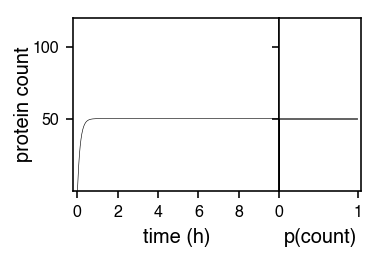

In [103]:
figsize = np.asarray(mpl.rcParams['figure.figsize'])*(.6,1)[::-1]

det_data = [det_data_dict[name] for name in ('low_var',)]

fac = 1
ylim = np.array([0, 120])*fac
yticks = np.arange(1,3)*50*fac

fig,axarr,axlab = plotts(det_data, ylim=ylim, yticks=yticks, figsize=figsize, truncate=(10*60*60 + 1))#, bins=(np.arange(75)-.5) )
ph.savefig(fig, 'simple_expression_timeseries_deterministic', '../../figures/');

/Users/tel/git/lma/lma/script/helvetica_hack.py:170: MathTextWarning: Font 'rm' does not have a glyph for 'b'\\cdot'' [U22c5]
  matplotlib.mathtext.MathTextWarning)
/Users/tel/git/lma/lma/script/helvetica_hack.py:187: MathTextWarning: Substituting equivalent glyph [Ub7] for 'b'\\cdot''
  matplotlib.mathtext.MathTextWarning)


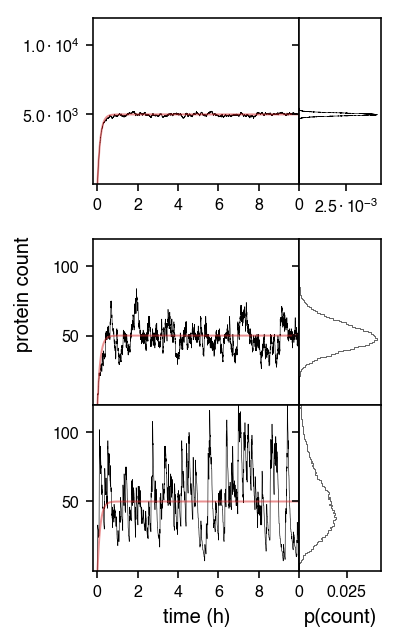

In [122]:
names = ['no_var', 'low_var', 'high_var']
cols = ('time', 'p')
det_data = [det_data_dict[name] for name in names]
stoch_data = getdata('../../data/simple_expression_all_stochastic.hdf', names, cols)
n = len(stoch_data)

hrat = .6*n + .12
figsize = np.asarray(mpl.rcParams['figure.figsize'])*(hrat,1)[::-1]
fig,axarr,axlab = ph.figAxArr([n+1, 2], axlab=True, sharey='row', figsize=figsize,
                              gridspec_kw={'height_ratios': [3,1,3,3], 'width_ratios': [2.5,1], 'wspace': 0, 'hspace': 0})
ph.hideAxesFrame(*axarr[1,:])

# bottom two panels
fac = 1
ylim = np.array([0, 120])*fac
yticks = np.arange(1,3)*50*fac

plotts(stoch_data[1:], ref_data=det_data[1:], ylim=ylim, yticks=yticks, truncate=(10*60*60 + 1),  # binrange=(0,149.9),
       labely=False, twinx=True, fig=fig, axarr=axarr[2:,:], axlab=axlab)
axarr[-1,1].xaxis.set_major_formatter(ph.linear_formatter(2))

# top panel
fac = 100
ylim = np.array([0, 120])*fac
yticks = np.arange(1,3)*50*fac

plotts(stoch_data[0:1], ref_data=det_data[0:1], ylim=ylim, yticks=yticks, truncate=(10*60*60 + 1),  # binrange=(0, 1.5e4 - 1), 
       labelx=False, labely=False, fig=fig, axarr=axarr[0:1,:], axlab=axlab)
axarr[0,0].yaxis.set_major_formatter(ph.sci_linear_formatter_curry(1))
axarr[0,1].xaxis.set_major_formatter(ph.sci_linear_formatter_curry(1))
# ph.hideAxesTicks(axarr[0,0], axis='x', hideticks=False, hideticklabels=True)

axlab.set_ylabel('protein count', labelpad=30)
ph.savefig(fig, 'simple_expression_timeseries_stochastic', '../../figures/');

# prepping data

In [77]:
def loadsavehdf(hdfpth, pths, names, dtypes, fixtime=True):
    with h5py.File(hdfpth, mode='w') as f:
        for pth,name,dtype in zip(pths, names, dtypes):
            print(f'saving dataset {name}... ', end='')
            # remove dataset if it exists
            if name in f:
                del f[name]
            
            if isinstance(dtype, (list, tuple)):
                arr = np.loadtxt(pth) if dtype is None else np.loadtxt(pth, dtype=dtype[0])
                arr = arr.astype(dtype=dtype[1])
            else:
                arr = np.loadtxt(pth) if dtype is None else np.loadtxt(pth, dtype=dtype)
                
            print(f'shape {arr.shape}... ', end='')
           
            if fixtime:
                arr['time'] = np.linspace(arr['time'][0], arr['time'][-1], arr['time'].size)
            
            f.create_dataset(name, data=arr, compression='gzip', compression_opts=9)
            print('done')

def doloadsavehdf(names, dtype, kind='stochastic'):
    args = [('../../data/simple_expression_%s_%s.txt' % (name, kind), name, dtype) for name in names]

    loadsavehdf('../../data/simple_expression_all_%s.hdf' % kind, *zip(*args))

In [78]:
dtype = np.dtype([('time', np.float32), ('g_p', np.int32), ('rna_p', np.int32), ('p', np.int32)])
names = ('no_var', 'min_var', 'low_var', 'high_var')

doloadsavehdf(names=names, dtype=dtype, kind='stochastic')

saving dataset no_var... shape (864001,)... done
saving dataset min_var... shape (864001,)... done
saving dataset low_var... shape (864001,)... done
saving dataset high_var... shape (864001,)... done


In [ ]:
dtypecomplete = np.dtype([('time', np.float32), ('g_p', np.int32), ('rna_p', np.int32), ('p', np.int32)])
dtypefloat = np.dtype([('time', np.float64), ('rna_p', np.float64), ('p', np.float64)])
dtype = np.dtype([('time', np.float32), ('rna_p', np.int32), ('p', np.int32)])
args = [
    ('../../data/simple_expression_no_var.txt', 'no_var', dtypecomplete),
    ('../../data/simple_expression_min_var.txt', 'min_var', (dtypefloat, dtype)),
    ('../../data/simple_expression_low_var.txt', 'low_var', (dtypefloat, dtype)),
    ('../../data/simple_expression_high_var.txt', 'high_var', (dtypefloat, dtype)),
]

loadsavehdf('../../data/simple_expression_stochastic_data.hdf', *zip(*args))

# 
# 
# 
# 
# old approach

In [ ]:
def plotts(data, xref=None, yref=None, yticks=(50,100,150), binrange=(0,149.9),
           fig=None, axarr=None, axlab=None, **fig_kw):
    if fig is None and axarr is None:
        fig,axarr,axlab = ph.figAxArr([len(data), 2], axlab=True, sharey=True,
                                      gridspec_kw={'width_ratios': [3,1], 'wspace': 0, 'hspace': 0}, **fig_kw)
    
    hs = []
    for (x,y),axrow in zip(np.asarray(data), axarr):
        ax,axhist = axrow
        ax.plot(x, y, color="k", lw=.3)
        if not (xref is None or yref is None):
            ax.plot(xref, yref, color="C3", alpha=.5)
        dx = x.max() - x.min()
        ax.set_xlim(x.min() - dx*.02, x.max())
        
        if yticks is None:
            ax.set_ylim(0, 1.1*y.max())
        else:
            ax.set_yticks(yticks)
            ax.set_ylim(0, 1.1*yticks[-1])

#         h = axhist.hist(y, bins=30, range=binrange, lw=.3, ec="k", fc="none", orientation="horizontal")
        
        histkw = {'bins': np.arange(-.5, np.ceil(d[1].max()) - .5) if bins is None else bins,
                  'range': binrange}
        h = axhist.hist(d[1], lw=.3, ec="k", fc="none", histtype='stepfilled', orientation="horizontal", density=True, **histkw)
        hs.append(h)
#         ph.hideAxesTicks(axhist)
    
    ph.reticktime(x, 'h', ax.xaxis)
    
    return fig,axarr,axlab

In [2]:
names = ('no_var', 'min_var', 'low_var', 'high_var')
cols = ('time', 'p')
data = getdata('../../data/simple_expression_stochastic_data.hdf', names, cols)

/Users/tel/git/lma/lma/script/helvetica_hack.py:170: MathTextWarning: Font 'rm' does not have a glyph for 'b'\\cdot'' [U22c5]
  matplotlib.mathtext.MathTextWarning)
/Users/tel/git/lma/lma/script/helvetica_hack.py:187: MathTextWarning: Substituting equivalent glyph [Ub7] for 'b'\\cdot''
  matplotlib.mathtext.MathTextWarning)


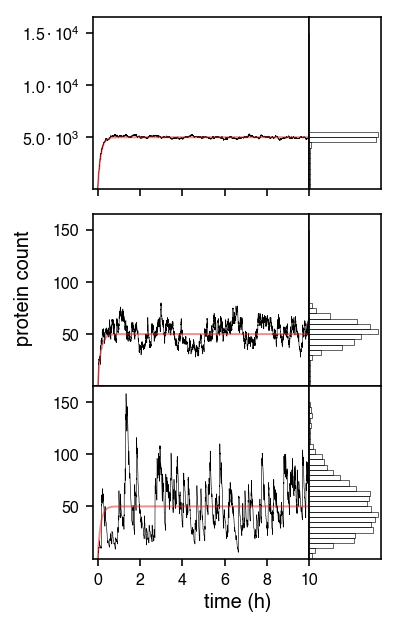

In [50]:
figsize = np.asarray(mpl.rcParams['figure.figsize'])*(1.88,1)[::-1]
fig,axarr,axlab = ph.figAxArr([4, 2], axlab=True, sharey='row', figsize=figsize,
                                      gridspec_kw={'height_ratios': [7,1,7,7], 'width_ratios': [3,1], 'wspace': 0, 'hspace': 0})
ph.hideAxesFrame(*axarr[1,:])

# bottom two panels
names = ['low_var', 'high_var']
cols = ('time', 'p')
data = getdata('../../data/simple_expression_stochastic_data.hdf', names, cols)

m = [1, 0, 0]
t = np.linspace(0, 10*60*60, int(1e5))
k = [1e-1, 1e-1, 1e-1, 2e-3]
yref = Y(k, t, m)[2]
xref = t

plotts(data, xref=xref, yref=yref, yticks=(50,100,150), binrange=(0,149.9), fig=fig, axarr=axarr[2:,:], axlab=axlab)

# top panel
names = ['no_var']
data = getdata('../../data/simple_expression_stochastic_data.hdf', names, cols)

k = [1e1, 1e-1, 1e-1, 2e-3]
yref = Y(k, t, m)[2]
xref = t

plotts(data, xref=xref, yref=yref, yticks=(int(5e3), int(1e4), int(1.5e4)), binrange=(0, 1.5e4 - 1), fig=fig, axarr=axarr[0:1,:], axlab=axlab)
axarr[0,0].yaxis.set_major_formatter(ph.sci_linear_formatter_curry(1))
ph.hideAxesTicks(axarr[0,0], axis='x', hideticks=False, hideticklabels=True)

axlab.set_xlabel('time (h)', labelpad=17)
axlab.set_ylabel('protein count', labelpad=30)

ph.savefig(fig, 'simple_expression_timeseries_stochastic', '../../figures/');

In [16]:
def loadtxtsavez(pth, name):
    arr = np.loadtxt(pth)
    np.savez_compressed(Path(pth).with_suffix(''), name=arr)
    return arr

In [9]:
stoch_data = np.load('../../notes/simple_expression_stochastic_data.npz')

list(stoch_data.keys())

['high_var_data', 'low_var_data', 'min_var_data']

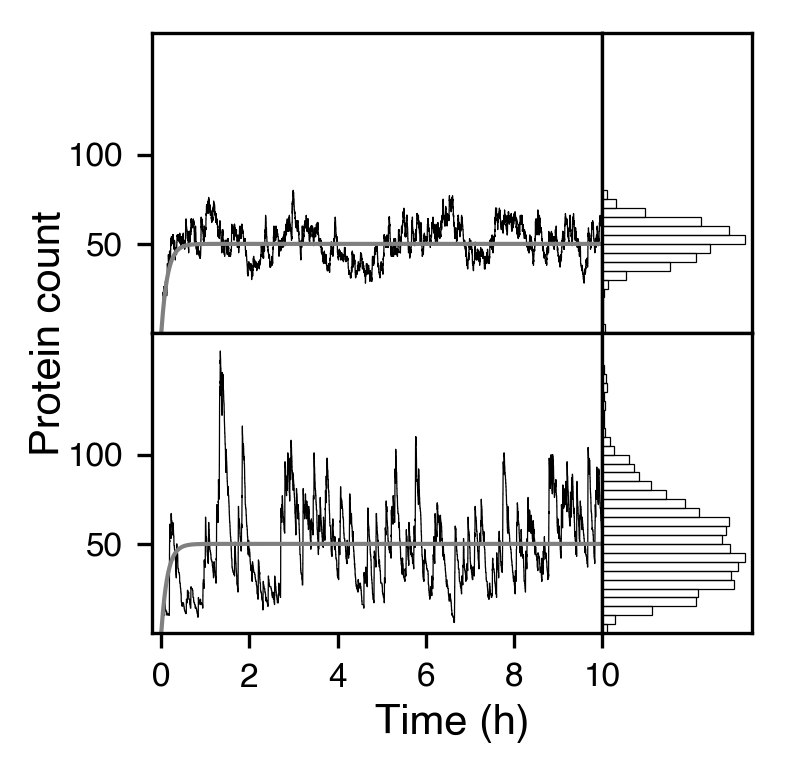

In [14]:
data = [stoch_data[k] for k in ('low_var_data', 'high_var_data')]
nrows = len(data)

fig, axarr = plt.subplots(nrows=nrows, ncols=2, sharey=True,
                          gridspec_kw={'width_ratios': [3,1], 'wspace': 0, 'hspace': 0})
axlab = fig.add_subplot(111, frameon=False)
fig.subplots_adjust(0,0,1,1)
tickkwargs = {m+k:False for k in ('bottom','top','left','right') for m in ('','label')}

hs = []
for data,axrow in zip(data, axarr):
    time,rna_p,p = data.T
    ax,axhist = axrow
    ax.plot(time, p, color="k", lw=.3)
    ax.plot(t,y[2], color="gray")
    ax.set_yticks([50, 100])
    xrange = time.max() - time.min()
    ax.set_xlim(time.min() - xrange*.02, time.max())
    ax.set_ylim(0, p.max()+10)

    h = axhist.hist(p, bins=30, range=(0,150), lw=.3, ec="k", fc="none", orientation="horizontal")
    hs.append(h)
    axhist.tick_params(axis="both", **tickkwargs)
    axhist.xaxis.get_offset_text().set_visible(False)

axarr[-1, 0].set_xticks([n*60*60 for n in np.arange(0,11,2)])
axarr[-1, 0].set_xticklabels([str(n) for n in np.arange(0, 11, 2)])
# axarr[-1, 0].set_xticklabels([str(n).zfill(2) + ':00' for n in np.arange(0, 10, 3)])

axlab.tick_params(axis="both", **tickkwargs)
axlab.set_xlabel('Time (h)', labelpad=17)
axlab.set_ylabel('Protein count', labelpad=20)
ph.savefig(fig, 'simple_expression_timeseries_fixed_mean', '../../figures/');

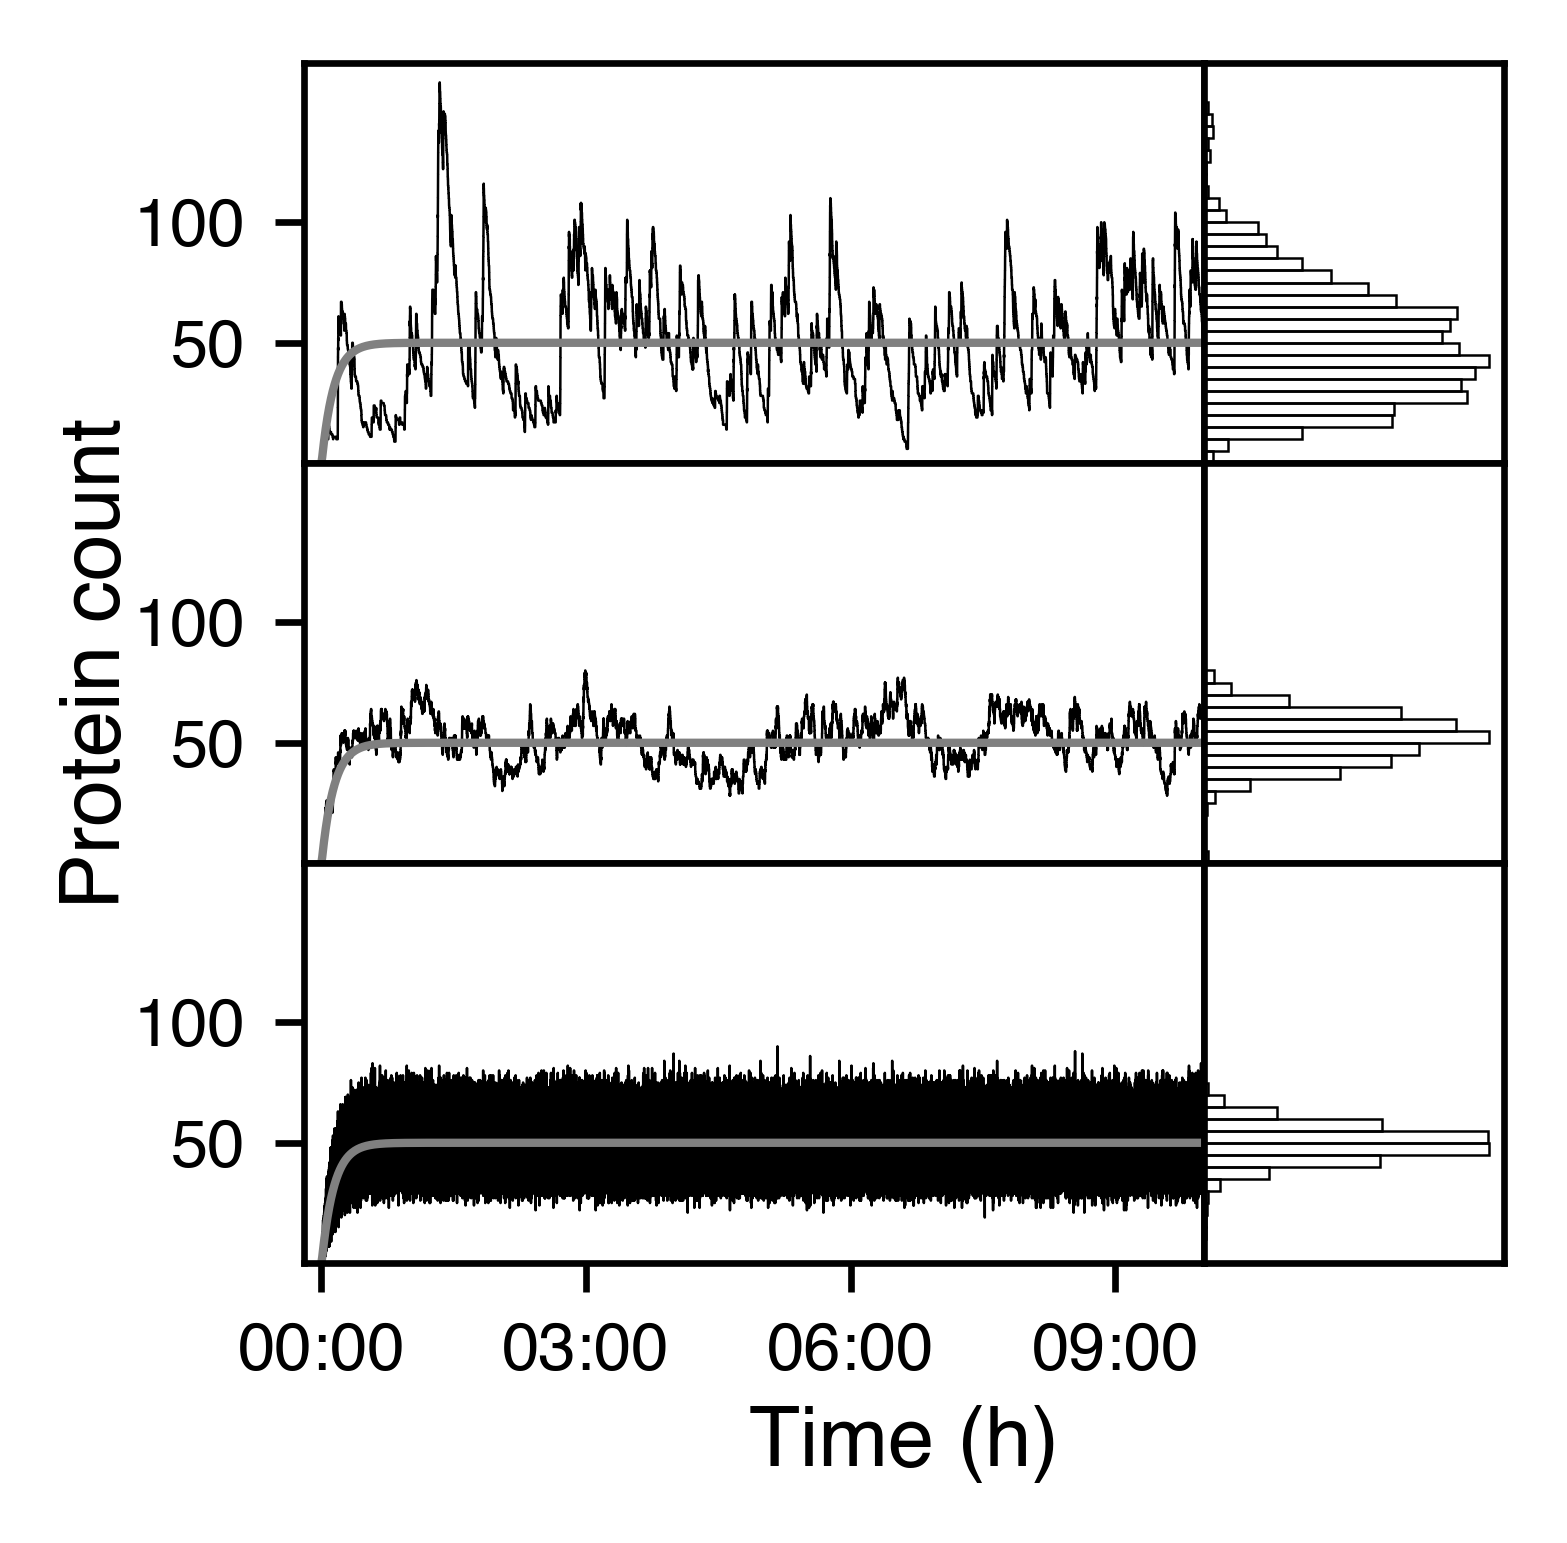

In [65]:
fig, axarr = plt.subplots(nrows=3, ncols=2, sharey=True,
                          gridspec_kw={'width_ratios': [3,1], 'wspace': 0, 'hspace': 0})
axlab = fig.add_subplot(111, frameon=False)
fig.subplots_adjust(0,0,1,1)
tickkwargs = {m+k:False for k in ('bottom','top','left','right') for m in ('','label')}

hs = []
for data,axrow in zip(stoch_data.values(), axarr):
    time,rna_p,p = data.T
    ax,axhist = axrow
    ax.plot(time, p, color="k", lw=.3)
    ax.plot(t,y[2], color="gray")
    ax.set_yticks([50, 100])
    xrange = time.max() - time.min()
    ax.set_xlim(time.min() - xrange*.02, time.max())
    ax.set_ylim(0, None)

    h = axhist.hist(p, bins=30, range=(0,150), lw=.3, ec="k", fc="none", orientation="horizontal")
    hs.append(h)
    axhist.tick_params(axis="both", **tickkwargs)
    axhist.xaxis.get_offset_text().set_visible(False)

axarr[-1, 0].set_xticks([n*60*60 for n in np.arange(0,11,2)])
axarr[-1, 0].set_xticklabels([str(n).zfill(2) + ':00' for n in np.arange(0, 10, 3)])

axlab.tick_params(axis="both", **tickkwargs)
axlab.set_xlabel('Time (h)', labelpad=17)
axlab.set_ylabel('Protein count', labelpad=20)
ph.savefig(fig, 'simple_expression_timeseries_fixed_mean', '../../figures/');